# Collating and cleaning fish data
This notebook collates and cleans the fish tracking data from [source](https://dx.doi.org/10.17617/3.4y).<br>
The dataset we are interested in are those files prepended with *reversals3m_1024_dotbot_20181025_105202*<br>
The data consists of the tracking observation data for approximately 1024 sunbleak fish in a 3m tank. Each fish has its observations contained in an individual .npz file, which we will combine. There are 40 frames per second for 500 seconds.

## Collating the fish data

In [1]:
# Import the usual stuff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Specify the folder location for the data

data_folder_location = "D:\\Data\\TRex data\\results_accurate_no_posture_data\\media\\recordings\\tristan\\paper\\2.Jun.20\\accurate_no_posture\\data\\reversals3m_1024_dotbot_20181025_105202\\"

### Warning: the following code takes about 1min20s to compute this cell. Concatenating dataframes is inefficient (it's better to concatenate lists and then convert to DataFrame at end).
 I will try to improve this when I get a chance, but for now it works. 

In [2]:
# This loads the individual files and stores them as a dataframe, then appends that dataframe to the previous dataframes
# The quantities we are interested in are the x and y positions, the time, the frame, and the fish number

# We will build the dataframe one fish at a time, but instead of initialising an empty dataframe we will start with the first fish, Fish 0

with np.load(data_folder_location+'reversals3m_1024_dotbot_20181025_105202.stitched_fish'+'0'+'.npz') as fish_data:
    npz = fish_data
    Fish = list(np.full(npz['time'].shape, 0, dtype=int))
    x = list(npz['X#wcentroid'])
    y = list(npz['Y#wcentroid'])
    t = list(npz['time'])
    frame = list(npz['frame'])
    frame = [int(f) for f in frame]
    fish_dict = {'Fish':Fish, 't':t, 'x':x, 'y':y, 'frame':frame}
    df = pd.DataFrame(fish_dict)

# We now iterate through the rest of the fish, creating and appending a dataframe for each fish to df.

for i in range(1,1126):

    with np.load(data_folder_location+'reversals3m_1024_dotbot_20181025_105202.stitched_fish'+str(i)+'.npz') as fish_data:
        npz = fish_data
        Fish = list(np.full(npz['time'].shape, i, dtype=int))
        x = list(npz['X#wcentroid'])
        y = list(npz['Y#wcentroid'])
        t = list(npz['time'])
        frame = list(npz['frame'])
        frame = [int(f) for f in frame]
        fish_dict = {'Fish':Fish, 't':t, 'x':x, 'y':y, 'frame':frame}
        df = pd.concat([df, pd.DataFrame(fish_dict)])



df = df.sort_values(['Fish','frame'])
df = df.set_index(['Fish', 'frame'])
print(df)

                     t          x           y
Fish frame                                   
0    8        0.224779  72.011169  119.371750
     9        0.249735        inf         inf
     10       0.274696  72.386383  119.354118
     11       0.299712  72.611839  119.335945
     12       0.324633  72.851936  119.275497
...                ...        ...         ...
1125 20009  499.824249  74.614189  117.827614
     20010  499.849274  74.443268  117.816742
     20011  499.874268  74.245605  117.802887
     20012  499.899292  73.972771  117.835457
     20013  499.924164  73.792877  117.878098

[22533844 rows x 3 columns]


## Cleaning the fish data

In [3]:
# Now that we have all of our data in a big dataframe, we can check to see if it is clean
# Let's start by looking at the datatypes of the columns

print(df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22533844 entries, (0, 8) to (1125, 20013)
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   t       float32
 1   x       float32
 2   y       float32
dtypes: float32(3)
memory usage: 344.5 MB
None


In [4]:
# This looks good. let's check out the max and min values

print('mins are: \n', df.min(), '\n')
print('maxs are: \n', df.max())

mins are: 
 t    0.000000
x    2.974756
y    3.064423
dtype: float32 

maxs are: 
 t    499.924164
x           inf
y           inf
dtype: float32


In [5]:
# Ok, this is a problem. The mins are fine, but the max contains "inf" in the x and y columns. This happens when TRex can't distinguish between two fish.
# We need to clean this up by replacing inf with an appropriate number.


# It seems that whenever x is inf, then y is also inf. We should first check this is true. 
print('x is "inf" if and only if y is also "inf": ', (df['x']==float('inf')).equals(df['y']==float('inf')))



x is "inf" if and only if y is also "inf":  True


### Imputing missing values in x and y position
The easiest method would be to just replace all inf with NaN, then sort by fish and time and fill forward. This would mean that any "inf" values are replaced by the value that the fish last had. The problem with this is that if there are multiple "inf" entries in a row, it might make the fish look like it is standing still and then jumping forward. A more sophisticated method would be to linearly interpolate the position of the fish between the value it had before the "inf" entries, and the value it had after.

In [6]:
# Let's do the quick and dirty thing first, and come back and improve this later

# First replace all the "inf" with NaN
df.loc[df['x'] == float('inf'), 'x'] = np.nan
df.loc[df['y'] == float('inf'), 'y'] = np.nan

# Now use forward fill to fill in the NaN values.
df = df.ffill(axis=0)

# Verify that we've removed the inf and the max is more sensible.  
print('number of "inf" in the x column: ', df['x'].isna().sum())
print('number of "inf" in the y column: ', df['y'].isna().sum())
print('maxs are: \n', df.max())

number of "inf" in the x column:  0
number of "inf" in the y column:  0
maxs are: 
 t    499.924164
x    119.099846
y    122.004288
dtype: float32


## Extracting velocities
We now turn our attention to extracting the velocities of the fish. The simplest way to do this is to just use the difference in position between two consecutive frames. We must be careful, however, to ensure that when the tracking 'jumps', that we don't include the velocity associated to that jump. This may be difficult to do perfectly, but a rough estimate would be to simply discard any velocities which are higher than the maximum speed of a sunbleak.

In [7]:
# This cell extracts the velocities of the fish. 


# The velocity is the difference between the next frame and the current frame.

# Create a new column, 'vx', which is the difference between the x column shifted by 1 and the x column
df['vx'] = df['x'].shift(-1) - df['x']

# Do the same thing for y
df['vy'] = df['y'].shift(-1) - df['y']



# The last row for each fish will be invalid since the velocities will have been calculated as the difference between their position and the position of another fish.
# We will set it to NaN. First get the (multi)indices of the last frames for each fish and store it in ind. 
# Then for each (multi)index in ind, set the vx and vy columns to nan

inds = df.groupby(level=0).tail(1).index.tolist()
for pair in inds:
    df.loc[pair, ('vx', 'vy')] = (np.nan, np.nan)

In [8]:
# Let's take another look at our dataframe and see if the velocities we have make sense

pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,t,x,y,vx,vy
count,22533844.000,22533844.000,22533844.000,22532718.000,22532718.000
mean,249.829,57.675,62.171,-0.000,-0.001
std,142.099,31.665,33.843,1.210,1.214
min,0.000,2.975,3.064,-109.888,-115.292
25%,124.975,30.336,32.269,-0.053,-0.053
50%,249.925,57.826,62.093,0.000,0.000
75%,374.949,85.636,92.094,0.053,0.056
max,499.924,119.100,122.004,110.203,115.593


### Replacing super large velocities with NaN
The mean velocity being very close to zero is reasonable, since the velocities point in all directions and the vector average would cancel out.
The max and min velocities, however, are cause for concern. We suspect that these are artifacts of the tracking 'jumping'.
That is, the tracking identifies a fish on one side of the tank in one frame, and then in the next frame thinks that fish is on the other side of the tank.

I think the best way to do this is to just apply a mask so if a velocity is above a given value, we set it to NaN.
After looking up [fish data](https://www.fishbase.in/summary/Leucaspius-delineatus.html) I have found that the average swimming speed for sunbleak is on the order of 0.58 m/s.
This is sustained swimming speeds, not burst speeds, but I think it's sensible to screen anything more than about 2 times this speed. 



In [9]:
# The velocities we have in our data are not in m/s. The x and y ranges for the data are approximately (0,125) and (0, 125), but the tank is 3m x 3m. 
# The time between frames is also 0.025s. If we want to screen velocities above 1 m/s, this corresponds to a velocity (in our units) of:

max_vel = 1*(125/3)/(40)
max_vel

1.0416666666666665

In [10]:
# Ok, so it turns out it doesn't really matter if we use our units or m/s, since they end up being roughly the same. 

# Subsetting the values where either the x or y velocities are above max_vel:
df.loc[(df['vx'].abs() >= max_vel) | (df['vy'].abs() >= max_vel), ('vx', 'vy')] = (np.nan, np.nan) 


In [11]:
df.describe()

,t,x,y,vx,vy
count,22533844.000,22533844.000,22533844.000,22049579.000,22049579.000
mean,249.829,57.675,62.171,-0.000,0.000
std,142.099,31.665,33.843,0.109,0.118
min,0.000,2.975,3.064,-1.041,-1.042
25%,124.975,30.336,32.269,-0.050,-0.050
50%,249.925,57.826,62.093,0.000,0.000
75%,374.949,85.636,92.094,0.050,0.053
max,499.924,119.100,122.004,1.042,1.042


In [12]:
# We see now that the x and y velocities are between -max_vel and max_vel, and the mean velocity didn't change substantially. It looks like we got a lot of the outliers. 

In [13]:
# Finally, we can add another column containing the instantaneous speed of the fish, given by sqrt(vx^2 + vy^2)

df['speed'] = (df['vx']**2 + df['vy']**2)**(1/2)

In [14]:
df.describe()

,t,x,y,vx,vy,speed
count,22533844.000,22533844.000,22533844.000,22049579.000,22049579.000,22049579.000
mean,249.829,57.675,62.171,-0.000,0.000,0.123
std,142.099,31.665,33.843,0.109,0.118,0.107
min,0.000,2.975,3.064,-1.041,-1.042,0.000
25%,124.975,30.336,32.269,-0.050,-0.050,0.000
50%,249.925,57.826,62.093,0.000,0.000,0.125
75%,374.949,85.636,92.094,0.050,0.053,0.191
max,499.924,119.100,122.004,1.042,1.042,1.470


## Simple data exploration

In [15]:
# The maximum and minimum ranges for the x and y values are:

print('x minimum is: ', df['x'].min())
print('x maximum is: ', df['x'].max())
print('y minimum is: ', df['y'].min())
print('y maximum is: ', df['y'].max())


# Given this, it seems a sensible range for x and y is x in (0, 125), y in (0,125).
xmin = 0
xmax = 125
ymin = 0
ymax = 125

x minimum is:  2.9747562408447266
x maximum is:  119.09984588623047
y minimum is:  3.064422607421875
y maximum is:  122.00428771972656


array([[<AxesSubplot:title={'center':'speed'}>]], dtype=object)

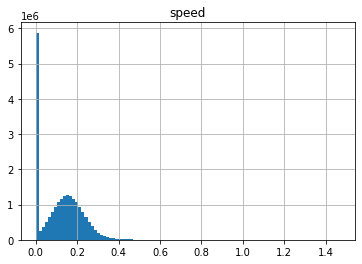

In [16]:
# We can look at the distribution of speeds
df.hist(column='speed', bins=100)

array([[<AxesSubplot:title={'center':'speed'}>]], dtype=object)

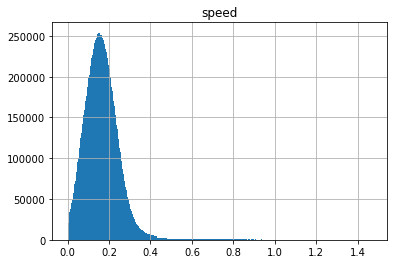

In [17]:
# We see that there is a huge peak at speed = 0, almost certainly corresponding to error introduced when we imputed the missing x and y values (mentioned earlier). 
# Away from this peak, we have what seems to be a lovely little distribution. Indeed, excluding the speed=0 terms we have:

df1 = pd.DataFrame(df).copy()
df1.loc[(df1['vx'].abs() == 0) | (df1['vy'].abs() == 0), ('vx', 'vy')] = (np.nan, np.nan) 
df1['speed'] = (df1['vx']**2 + df1['vy']**2)**(1/2)
df1.hist(column='speed', bins=500)

In [18]:
# Gorgeous!

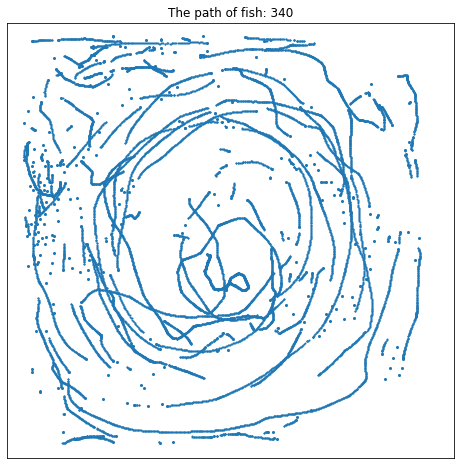

In [19]:
# Let's look at a random fish, and look at its (x,y) position over time
# First, pick a random fish 

testfish = 340

fig, ax = plt.subplots()


ax.scatter(df.loc[testfish,:]['x'], df.loc[testfish,:]['y'], s=1, c='tab:blue')


ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

ax.set_title(str("The path of fish: " + str(testfish)))

fig.set_size_inches(8,8)
plt.show()

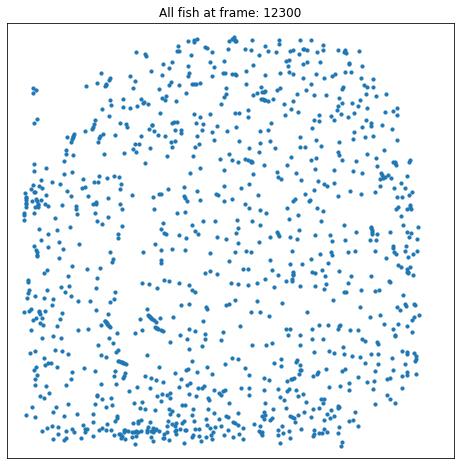

In [20]:
# Alternatively, we can look at all the fish at a given frame
# First, pick a random frame
testframe= 12300


fig, ax = plt.subplots()


ax.scatter(df[df.index.get_level_values(1)==testframe]['x'], df[df.index.get_level_values(1)==testframe]['y'], s=10, c='tab:blue')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

ax.set_title(str("All fish at frame: " + str(testframe)))

fig.set_size_inches(8,8)
plt.show()

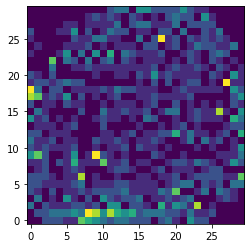

In [21]:
# It would be interesting to see a heatmap of the density of fish
# The quick and dirty way of doing this is via numpys histogram2d

# For a random time, this is the heatmap
heatmap, xedges, yedges = np.histogram2d(df[df.index.get_level_values(1)==testframe]['x'], df[df.index.get_level_values(1)==testframe]['y'], bins=(30,30))
plt.imshow(heatmap.T, origin='lower')

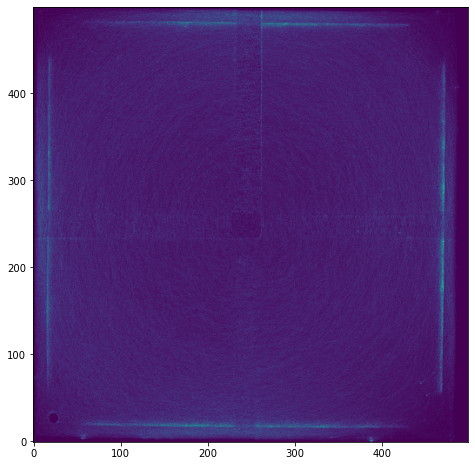

In [22]:
# We can also do this for all x and y values in a given timeframe, and in particular, for the entire dataset

heatmap, xedges, yedges = np.histogram2d(df[(df.index.get_level_values(1) >= 0)]['x'], df[(df.index.get_level_values(1) >= 0)]['y'], bins=(500,500))
plt.figure(figsize=(8,8))

plt.imshow(heatmap.T, origin='lower')

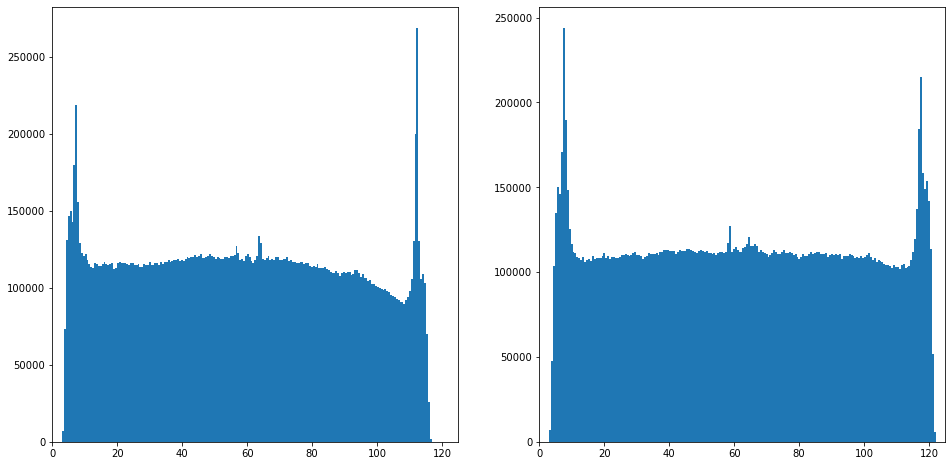

In [23]:
# In the previous image we saw some interesting things!
# Averaged over the whole time, the fish tend to congregate around the outside of the tank
# We can see this clearly in the distributions of the x and y positions

fig, ax = plt.subplots(1,2)


ax[0].hist(df['x'], bins=200)
ax[1].hist(df['y'], bins=200)

ax[0].set_xlim((xmin, xmax))
ax[1].set_xlim((ymin, ymax))



fig.set_size_inches(16,8)

plt.show()

In [24]:
# We can also see the artifacts of the video stitching in the centre of the arena. We will need to keep both of these in mind during our later analysis. 

In [25]:
# Finally, let us save the DataFrame to a csv file so we can use it later
df.to_csv('1024sunbleak_clean.csv')